#### Required Python libraries

In [4]:
import numpy  as np
import matplotlib.pyplot as plt
import librosa  # package for speech and audio analysis
from sklearn import mixture
from sklearn.metrics import accuracy_score,confusion_matrix
from scipy.io import loadmat
from scipy.io import savemat
from torchvision import datasets, transforms
from sklearn.preprocessing import StandardScaler
import pylab as pl
import seaborn as sns
import pandas as pd
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.utils.fixes import loguniform
from sklearn.multiclass import OneVsRestClassifier
%config InlineBackend.figure_format = 'retina'   ##QUALITY FIGURES!!
import time

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Number of observations in the training set: 17736
Person 0 Z axis acelerometer


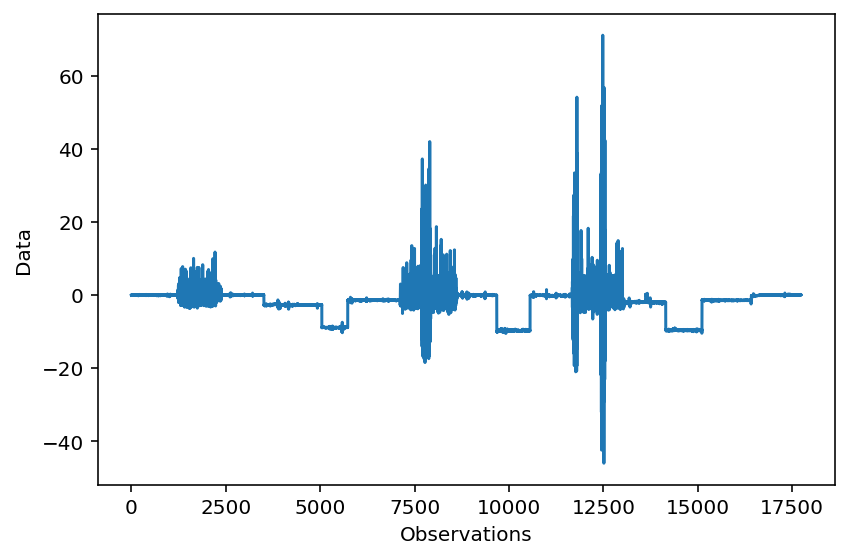

Person 1 XY axis acelerometer


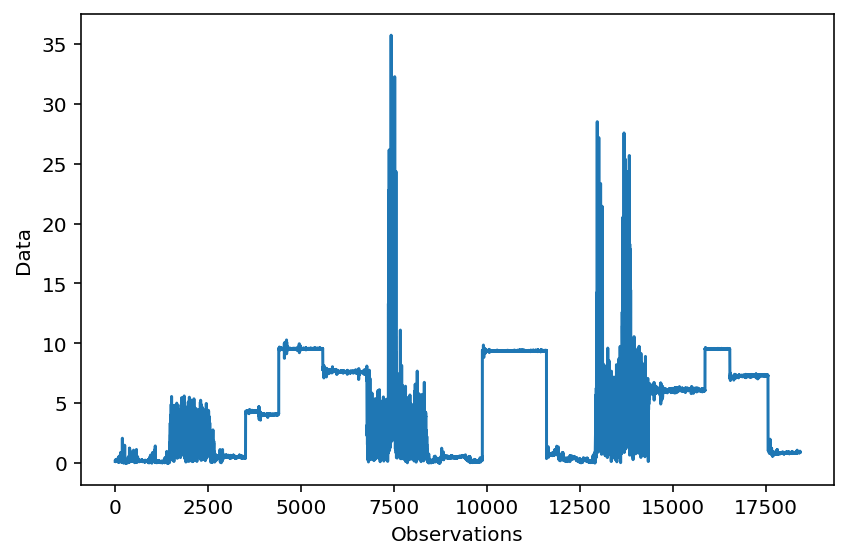

In [5]:
x = loadmat('HAR_database.mat')

print("Number of observations in the training set: %d" %len(x['database_training'][0][0][0]))

print("Person 0 Z axis acelerometer")
plt.plot(x['database_training'][0][0][0])
plt.ylabel("Data")
plt.xlabel("Observations")
plt.tight_layout()
plt.show()
print("Person 1 XY axis acelerometer")
plt.plot(x['database_training'][1][0][1])
plt.ylabel("Data")
plt.xlabel("Observations")
plt.tight_layout()
plt.show()




### Prepare the data:

In [6]:
numberOfSamples = 0
for i in range(0,8):
    numberOfSamples = numberOfSamples + len(x['database_training'][i][0][0])
print("Total number of samples:")
print(numberOfSamples)
X_training = np.empty((0, 5))
Y_training = np.empty((0, 1))

for i in range(0,8):
    X_training_aux = np.empty((len(x['database_training'][i][0][0]), 0))
    for j in range(0,5):
        X_training_aux = np.hstack((X_training_aux, np.atleast_2d(x['database_training'][i][0][j] ).T))
        X_training = np.append(X_training,X_training_aux,axis=0)
        Y_training =  np.append(Y_training,x['database_training'][i][1])
  

print("X training shape: ")
print(X_training.shape)
print("Y training shape: ")
print(Y_training.shape)



Total number of samples:
141426
X training shape: 
(141426, 5)
Y training shape: 
(141426,)


In [7]:
numberOfSamples = 0
for i in range(0,2):
    numberOfSamples = numberOfSamples + len(x['database_test'][i][0][0])
print("Total number of samples:")
print(numberOfSamples)

len_person1 = len(x['database_test'][0][0][0])
len_person2 = len(x['database_test'][1][0][0])

X_testing = np.empty((0, 5))

for i in range(0,2):

    X_testing_aux = np.empty((len(x['database_test'][i][0][0]), 0))
    for j in range(0,5):
        X_testing_aux = np.hstack((X_testing_aux, np.atleast_2d(x['database_test'][i][0][j] ).T))

    X_testing = np.append(X_testing,X_testing_aux,axis=0)
 
print("X testing shape: ")  
print(X_testing.shape)


Total number of samples:
42188
X testing shape: 
(42188, 5)


In [0]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_training)
X_test_scaled = scaler.transform(X_testing)

In [0]:
#We are using 5-cross validation for tuning hyper-parameters
n_estimators = 10

start = time.time()
clf_1 = OneVsRestClassifier(BaggingClassifier(SVC(cache_size=7000), max_samples=1.0 / n_estimators, n_estimators=n_estimators))

grid_svc = GridSearchCV(clf_1,
                        param_grid={'estimator__base_estimator__kernel': ['rbf'],
                                    'estimator__base_estimator__gamma': [1e-2,1e-3, 1e-4],
                                    'estimator__base_estimator__C': [100,1000,2000,3000]
                                    },
                        cv=5)

grid_svc.fit(X_train_scaled, Y_training)
y_pred = grid_svc.predict(X_test_scaled)

# View the best parameters for the model found using grid search
print('Best C:',grid_svc.best_estimator_.estimator.base_estimator.C,"\n") 
print('Best Kernel:',grid_svc.best_estimator_.estimator.base_estimator.kernel,"\n")
print('Best Gamma:',grid_svc.best_estimator_.estimator.base_estimator.gamma,"\n")

final_model = grid_svc.best_estimator_
Y_pred_SVC = final_model.predict(X_test_scaled)
#print(Y_pred)

score_SVC = final_model.score(X_train_scaled,Y_training)*100
end = time.time()

time_SVC = end - start

print ("Bagging SVC score:", score_SVC, "% ")
print ("Bagging SVC time:", time_SVC, " seconds")
data = {'Y_pred_SVC' : Y_pred_SVC}
savemat('Y_pred_SVC.mat', data)


Best C: 3000 

Best Kernel: rbf 

Best Gamma: 0.01 

Bagging SVC score: 94.5809115721296 % 
Bagging SVC time: 10636.333085775375  seconds


In [9]:

start = time.time()


rfc = RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [200,400,500,800],
    'max_features': ['auto'],
    'max_depth' :[2,5,10,20]
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=3)
CV_rfc.fit(X_train_scaled, Y_training)

final_model_RF = CV_rfc.best_estimator_

Y_pred_RF = final_model_RF.predict(X_test_scaled)

end = time.time()
time_RF = end - start
score_RF = final_model_RF.score(X_train_scaled,Y_training)*100

print ("Random Forest score:", score_RF , "% ")
print ("Random Forest time:", time_RF, " seconds")

data = {'Y_pred_RF' : Y_pred_RF}
savemat('Y_pred_RF.mat', data)


Random Forest score: 97.14126115424321 % 
Random Forest time: 4040.826635360718  seconds


In [0]:
from sklearn.naive_bayes import GaussianNB

start = time.time()

#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(X_train_scaled, Y_training)

#Predict the response for test dataset
y_pred_GNB = gnb.predict(X_test_scaled)

end = time.time()
time_GNB = end - start

score_GSB = gnb.score(X_train_scaled,Y_training)*100

#print(y_pred)
print ("Gaussian Naive Bayes score:", score_GSB, "% ")
print ("Gaussian Naive Bayes time:", time_GNB, " seconds")

data = {'y_pred_GNB' : y_pred_GNB}
savemat('y_pred_GNB.mat', data)


Gaussian Naive Bayes score: 92.33874959342695 % 
Gaussian Naive Bayes time: 0.05122113227844238  seconds


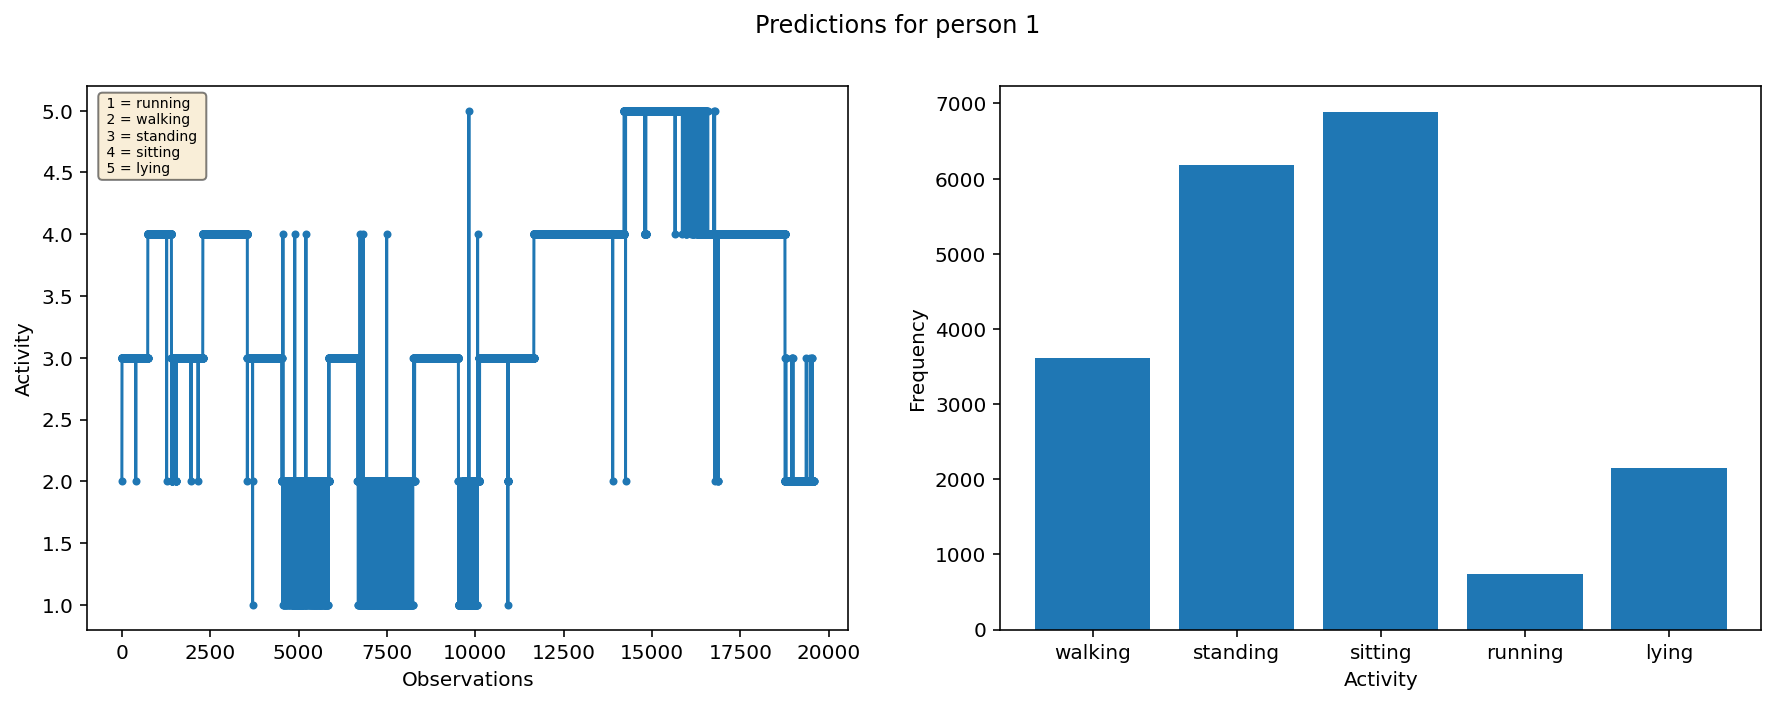

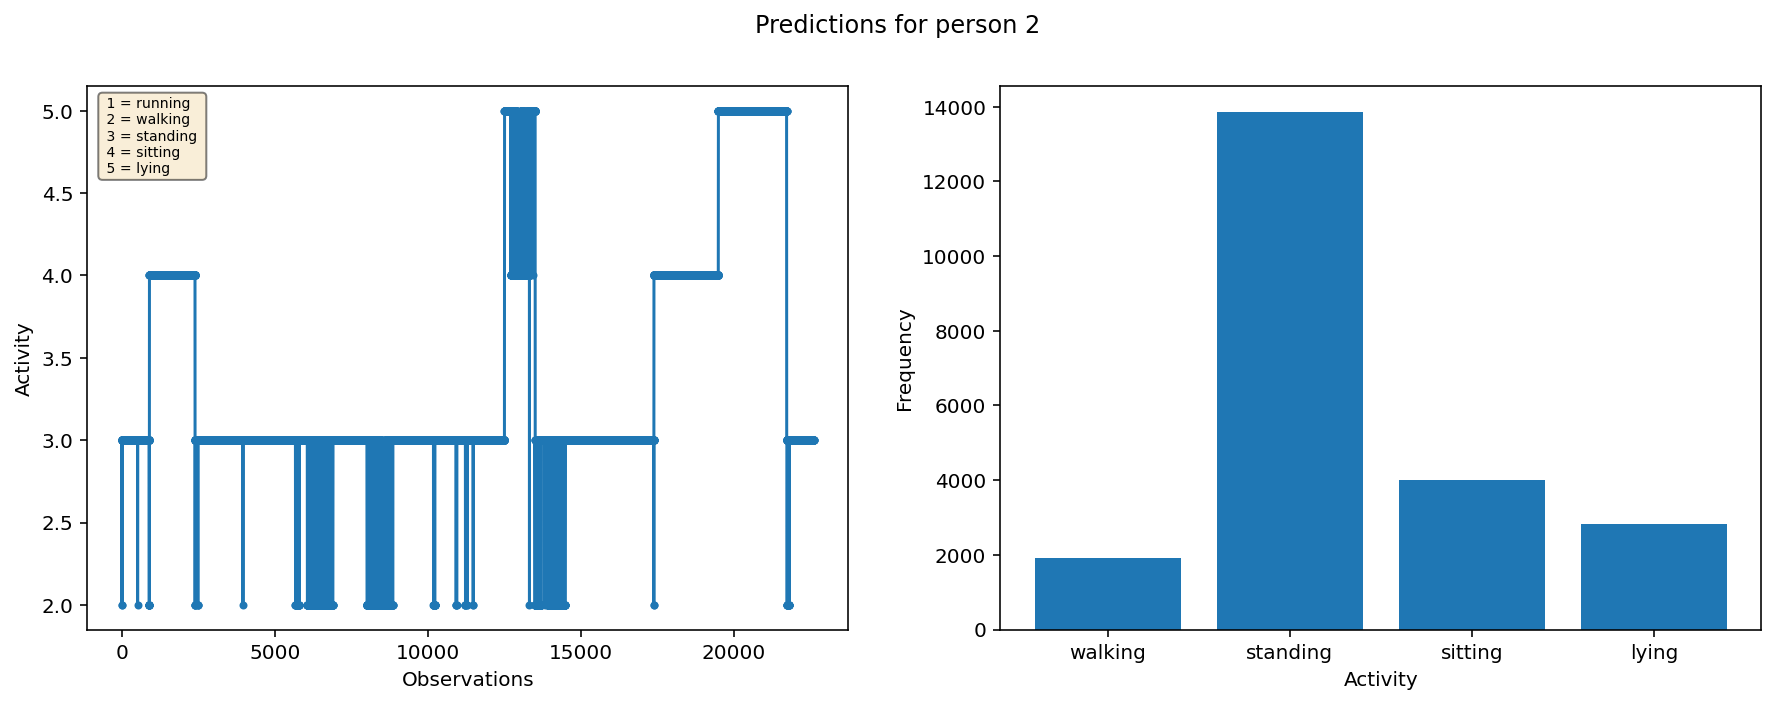

In [35]:

Y_pred_RF_uncoded = []
i = 0
for data in Y_pred_RF_int:
    if data == 1:
        Y_pred_RF_uncoded.append("running")
    if data == 2:
        Y_pred_RF_uncoded.append("walking")
    if data == 3:
        Y_pred_RF_uncoded.append("standing")
    if data == 4:
        Y_pred_RF_uncoded.append("sitting")
    if data == 5:
        Y_pred_RF_uncoded.append("lying")
    i = i+1

Y_pred_person1_uncoded = Y_pred_RF_uncoded[0:len_person1]
Y_pred_person2_uncoded = Y_pred_RF_uncoded[len_person1:Y_pred_RF.shape[0]]
Y_pred_person1 = Y_pred_RF[0:len_person1]
Y_pred_person2 = Y_pred_RF[len_person1:Y_pred_RF.shape[0]]

import collections
import matplotlib.lines as mlines

col = collections.Counter(Y_pred_person1_uncoded)
names = list(col.keys())
values = list(col.values())


fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Predictions for person 1')
fig.set_size_inches(15, 5)

ax1.plot(Y_pred_person1, marker=".")

ax1.set_ylabel("Activity")
ax1.set_xlabel("Observations")
ax2.bar(names, values)
ax2.set_ylabel("Frequency")
ax2.set_xlabel("Activity")

textstr = '\n'.join((
    " 1 = running ",
    " 2 = walking ",
    " 3 = standing ",
    " 4 = sitting ",
    " 5 = lying "
    ))

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax1.text(0.02, 0.98, textstr, transform= ax1.transAxes, fontsize=7,
        verticalalignment='top', bbox=props)

plt.show()

print("\n")
col = collections.Counter(Y_pred_person2_uncoded)
names = list(col.keys())
values = list(col.values())


fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Predictions for person 2')
fig.set_size_inches(15, 5)
ax1.plot(Y_pred_person2, marker=".")
ax1.set_ylabel("Activity")
ax1.set_xlabel("Observations")
ax2.bar(names, values)
ax2.set_ylabel("Frequency")
ax2.set_xlabel("Activity")
textstr = '\n'.join((
    " 1 = running ",
    " 2 = walking ",
    " 3 = standing ",
    " 4 = sitting ",
    " 5 = lying "
    ))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax1.text(0.02, 0.98, textstr, transform= ax1.transAxes, fontsize=7,
        verticalalignment='top', bbox=props)
plt.show()